In [1]:
import numpy as np
import scanpy as sc
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import scanpy as sc
import pandas as pd
import glob
from tqdm import tqdm_notebook
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, cohen_kappa_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.stats import ttest_ind
import shap

In [13]:
seed = 42
shap.initjs()

### load data

In [3]:
data_dict = {}
gene_list = []
for f in tqdm_notebook(glob.glob("/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/*")):
    data = sc.read_h5ad(f)
    f = f.replace('/home/scai/processing_simoncai/10xfreshfrozen/data/adata/no_filter/','').replace('.h5ad','')
#     sc.pp.filter_cells(data, min_genes=5)
#     sc.pp.filter_genes(data, min_counts=50)
    #sc.pp.normalize_total(data)
    data_dict[f] = data
    gene_list = data.var_names

# visually decide thresholds

In [9]:
combined = {}
for sample in sorted(data_dict):
    sample_name = '_'.join(sample.split('_')[:3])
    combined[sample_name] = np.log10(np.sum(data_dict[sample].X.toarray(), axis=1) + 1)

In [10]:
threshold_dict = {}

## D1

### D1 FA2

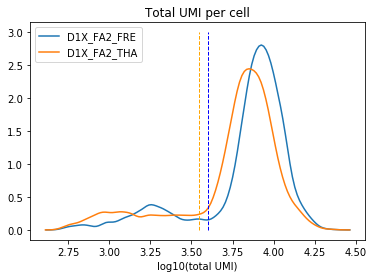

In [11]:
threshold_fre = 4000
threshold_tha = 3500
threshold_dict['D1X_FA2_FRE'] = threshold_fre
threshold_dict['D1X_FA2_THA'] = threshold_tha

sns.distplot(combined['D1X_FA2_FRE'], hist=False, label='D1X_FA2_FRE')
sns.distplot(combined['D1X_FA2_THA'], hist=False, label='D1X_FA2_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.plot(
    [np.log10(threshold_fre), np.log10(threshold_fre)], [0, 3],
    color='blue',
    linewidth=1,
    linestyle='--')
plt.plot(
    [np.log10(threshold_tha), np.log10(threshold_tha)], [0, 3],
    color='orange',
    linewidth=1,
    linestyle='--')
plt.show()

In [12]:
print(f"FRE filtered {np.sum(combined['D1X_FA2_FRE'] < np.log10(threshold_fre))}")
print(f"THA filtered {np.sum(combined['D1X_FA2_THA'] < np.log10(threshold_fre))}")

FRE filtered 625
THA filtered 1176


### D1 FA3

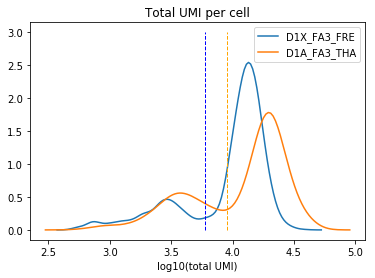

In [13]:
threshold_fre = 6000
threshold_tha = 9000
threshold_dict['D1X_FA3_FRE'] = threshold_fre
threshold_dict['D1A_FA3_THA'] = threshold_tha

sns.distplot(combined['D1X_FA3_FRE'], hist=False, label='D1X_FA3_FRE')
sns.distplot(combined['D1A_FA3_THA'], hist=False, label='D1A_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.plot(
    [np.log10(threshold_fre), np.log10(threshold_fre)], [0, 3],
    color='blue',
    linewidth=1,
    linestyle='--')
plt.plot(
    [np.log10(threshold_tha), np.log10(threshold_tha)], [0, 3],
    color='orange',
    linewidth=1,
    linestyle='--')
plt.show()

In [14]:
print(f"FRE filtered {np.sum(combined['D1X_FA3_FRE'] < np.log10(threshold_fre))}")
print(f"THA filtered {np.sum(combined['D1A_FA3_THA'] < np.log10(threshold_fre))}")

FRE filtered 622
THA filtered 916


## D4

### D4 FA2

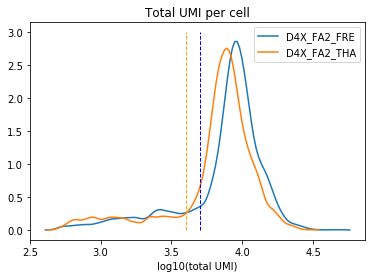

In [15]:
threshold_fre = 5000
threshold_tha = 4000
threshold_dict['D4X_FA2_FRE'] = threshold_fre
threshold_dict['D4X_FA2_THA'] = threshold_tha

sns.distplot(combined['D4X_FA2_FRE'], hist=False, label='D4X_FA2_FRE')
sns.distplot(combined['D4X_FA2_THA'], hist=False, label='D4X_FA2_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.plot(
    [np.log10(threshold_fre), np.log10(threshold_fre)], [0, 3],
    color='blue',
    linewidth=1,
    linestyle='--')
plt.plot(
    [np.log10(threshold_tha), np.log10(threshold_tha)], [0, 3],
    color='orange',
    linewidth=1,
    linestyle='--')
plt.show()

In [16]:
print(f"FRE filtered {np.sum(combined['D4X_FA2_FRE'] < np.log10(threshold_fre))}")
print(f"THA filtered {np.sum(combined['D4X_FA2_THA'] < np.log10(threshold_fre))}")

FRE filtered 644
THA filtered 1049


### D4 FA3

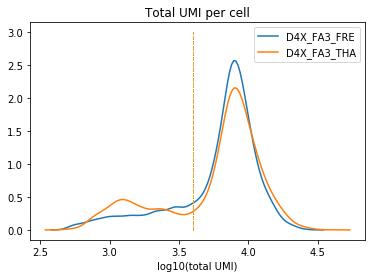

In [17]:
threshold_fre = 4000
threshold_tha = 4000
threshold_dict['D4X_FA3_FRE'] = threshold_fre
threshold_dict['D4X_FA3_THA'] = threshold_tha

sns.distplot(combined['D4X_FA3_FRE'], hist=False, label='D4X_FA3_FRE')
sns.distplot(combined['D4X_FA3_THA'], hist=False, label='D4X_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.plot(
    [np.log10(threshold_fre), np.log10(threshold_fre)], [0, 3],
    color='blue',
    linewidth=1,
    linestyle='--')
plt.plot(
    [np.log10(threshold_tha), np.log10(threshold_tha)], [0, 3],
    color='orange',
    linewidth=1,
    linestyle='--')
plt.show()

In [18]:
print(f"FRE filtered {np.sum(combined['D4X_FA3_FRE'] < np.log10(threshold_fre))}")
print(f"THA filtered {np.sum(combined['D4X_FA3_THA'] < np.log10(threshold_fre))}")

FRE filtered 705
THA filtered 1169


# Set low-quality cells

In [236]:
combined = {}
for sample in tqdm_notebook(sorted(data_dict)):
    sample_name = '_'.join(sample.split('_')[:3])
    tmp = data_dict[sample].to_df()
    if sample_name not in threshold_dict.keys():
        continue
    tmp['low_quality'] = tmp.apply(
        lambda row: True if np.sum(row) < threshold_dict[sample_name] else False,
        axis=1)
    tmp['sample'] = sample_name
    combined[sample_name] = tmp

In [ ]:
combined_df = pd.concat(combined)

In [129]:
combined_holdout_df = combined_df[combined_df['sample'].str.startswith('D4X_FA3')]
combined_train_df = combined_df[~combined_df['sample'].str.startswith('D4X_FA3')]

In [130]:
combined_train_fre_df = combined_train_df[combined_train_df['sample'].str.endswith('FRE')]
combined_train_tha_df = combined_train_df[combined_train_df['sample'].str.endswith('THA')]

combined_holdout_fre_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('FRE')]
combined_holdout_tha_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('THA')]

# ML

## train fresh only predict both

In [170]:
X = combined_train_fre_df.drop(['low_quality', 'sample'], axis=1)
y = combined_train_fre_df['low_quality']

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=seed)

In [172]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

### check within train performance

In [173]:
clf = LGBMClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
X_test = scaler.fit_transform(X_test)
y_conf = clf.predict_proba(X_test)[:,1]

In [176]:
print(f"AUC: {roc_auc_score(y_test, y_conf)}")
print(f"Accuracy: {accuracy_score(y_test, y_conf>0.5)}")
print(f"F1: {f1_score(y_test, (y_conf>0.5))}")
print(f"Kappa: {cohen_kappa_score(y_test, (y_conf>0.5))}")
print(confusion_matrix(y_test, (y_conf>0.5)))

AUC: 0.9997540533893335
Accuracy: 0.9931906614785992
F1: 0.9814323607427056
Kappa: 0.9772632483601481
[[836   3]
 [  4 185]]


In [177]:
X_tha = combined_train_tha_df.drop(['low_quality', 'sample'], axis=1)
X_tha = scaler.fit_transform(X_tha)
y_tha = combined_train_tha_df['low_quality']
y_tha_conf = clf.predict_proba(X_tha)[:,1]

In [178]:
print(f"AUC: {roc_auc_score(y_tha, y_tha_conf)}")
print(f"Accuracy: {accuracy_score(y_tha, y_tha_conf>0.5)}")
print(f"F1: {f1_score(y_tha, (y_tha_conf>0.5))}")
print(f"Kappa: {cohen_kappa_score(y_tha, (y_tha_conf>0.5))}")
print(confusion_matrix(y_tha, (y_tha_conf>0.5)))

AUC: 0.9929166856978208
Accuracy: 0.9691127287035215
F1: 0.9154853759196124
Kappa: 0.8967480299974567
[[12227     4]
 [  467  2551]]


### check holdout performance

In [179]:
X_fre_holdout = combined_holdout_fre_df.drop(['low_quality', 'sample'], axis=1)
y_fre_holdout = combined_holdout_fre_df['low_quality']
X_fre_holdout = scaler.fit_transform(X_fre_holdout)
y_fre_holdout_conf = clf.predict_proba(X_fre_holdout)[:,1]

In [180]:
print(f"AUC: {roc_auc_score(y_fre_holdout, y_fre_holdout_conf)}")
print(f"Accuracy: {accuracy_score(y_fre_holdout, y_fre_holdout_conf>0.5)}")
print(f"F1: {f1_score(y_fre_holdout, (y_fre_holdout_conf>0.5))}")
print(f"Kappa: {cohen_kappa_score(y_fre_holdout, (y_fre_holdout_conf>0.5))}")
print(confusion_matrix(y_fre_holdout, (y_fre_holdout_conf>0.5)))

AUC: 0.9980824604273997
Accuracy: 0.9796452457109625
F1: 0.949928469241774
Kappa: 0.937155927856582
[[2705   29]
 [  41  664]]


In [181]:
X_tha_holdout = combined_holdout_tha_df.drop(['low_quality', 'sample'], axis=1)
y_tha_holdout = combined_holdout_tha_df['low_quality']
X_tha_holdout = scaler.fit_transform(X_tha_holdout)
y_tha_holdout_conf = clf.predict_proba(X_tha_holdout)[:,1]

In [182]:
print(f"AUC: {roc_auc_score(y_tha_holdout, y_tha_holdout_conf)}")
print(f"Accuracy: {accuracy_score(y_tha_holdout, y_tha_holdout_conf>0.5)}")
print(f"F1: {f1_score(y_tha_holdout, (y_tha_holdout_conf>0.5))}")
print(f"Kappa: {cohen_kappa_score(y_tha_holdout, (y_tha_holdout_conf>0.5))}")
print(confusion_matrix(y_tha_holdout, (y_tha_holdout_conf>0.5)))

AUC: 0.9994060039479984
Accuracy: 0.9855103345408055
F1: 0.9702537182852143
Kappa: 0.9606828036978794
[[3516    8]
 [  60 1109]]


## train both predict both

In [301]:
X = combined_train_df.drop(['low_quality', 'sample'], axis=1)
y = combined_train_df['low_quality']

In [184]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=seed)

In [185]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

### check within train performance

In [186]:
clf = LGBMClassifier(n_estimators=100, n_jobs=-1)
clf.fit(X_train, y_train)
X_test = scaler.fit_transform(X_test)
y_conf = clf.predict_proba(X_test)[:,1]

In [187]:
print(f"AUC: {roc_auc_score(y_test, y_conf)}")
print(f"Accuracy: {accuracy_score(y_test, y_conf>0.5)}")
print(f"F1: {f1_score(y_test, (y_conf>0.5))}")
print(f"Kappa: {cohen_kappa_score(y_test, (y_conf>0.5))}")
print(confusion_matrix(y_test, (y_conf>0.5)))

AUC: 0.9994169678176117
Accuracy: 0.987460815047022
F1: 0.9671457905544149
Kappa: 0.9593982525100158
[[2049   12]
 [  20  471]]


### check holdout performance

In [188]:
X_fre_holdout = combined_holdout_fre_df.drop(['low_quality', 'sample'], axis=1)
y_fre_holdout = combined_holdout_fre_df['low_quality']
X_fre_holdout = scaler.fit_transform(X_fre_holdout)
y_fre_holdout_conf = clf.predict_proba(X_fre_holdout)[:,1]

In [189]:
print(f"AUC: {roc_auc_score(y_fre_holdout, y_fre_holdout_conf)}")
print(f"Accuracy: {accuracy_score(y_fre_holdout, y_fre_holdout_conf>0.5)}")
print(f"F1: {f1_score(y_fre_holdout, (y_fre_holdout_conf>0.5))}")
print(f"Kappa: {cohen_kappa_score(y_fre_holdout, (y_fre_holdout_conf>0.5))}")
print(confusion_matrix(y_fre_holdout, (y_fre_holdout_conf>0.5)))

AUC: 0.998655750802866
Accuracy: 0.9802268101192207
F1: 0.9532967032967034
Kappa: 0.9407710812370165
[[2677   57]
 [  11  694]]


In [190]:
X_tha_holdout = combined_holdout_tha_df.drop(['low_quality', 'sample'], axis=1)
y_tha_holdout = combined_holdout_tha_df['low_quality']
X_tha_holdout = scaler.fit_transform(X_tha_holdout)
y_tha_holdout_conf = clf.predict_proba(X_tha_holdout)[:,1]

In [191]:
print(f"AUC: {roc_auc_score(y_tha_holdout, y_tha_holdout_conf)}")
print(f"Accuracy: {accuracy_score(y_tha_holdout, y_tha_holdout_conf>0.5)}")
print(f"F1: {f1_score(y_tha_holdout, (y_tha_holdout_conf>0.5))}")
print(f"Kappa: {cohen_kappa_score(y_fre_holdout, (y_fre_holdout_conf>0.5))}")
print(confusion_matrix(y_tha_holdout, (y_tha_holdout_conf>0.5)))

AUC: 0.9995618459853441
Accuracy: 0.9912635840613679
F1: 0.9823958780592529
Kappa: 0.9407710812370165
[[3508   16]
 [  25 1144]]


# cross holdout

In [338]:
combined = {}
for sample in tqdm_notebook(sorted(data_dict)):
    sample_name = '_'.join(sample.split('_')[:3])
    tmp = data_dict[sample].to_df()
    if sample_name not in threshold_dict.keys():
        continue
    tmp['low_quality'] = tmp.apply(
        lambda row: True if np.sum(row) < threshold_dict[sample_name] else False,
        axis=1)
    tmp['sample'] = sample_name
    combined[sample_name] = tmp
combined_df = pd.concat(combined)

In [339]:
combined_df['sample'] = combined_df['sample'].str.replace('D1A','D1X')
combined_df = combined_df.reset_index(drop=True)

In [342]:
columns = [
    'val_AUC_freshonly',
    'val_Accuracy_freshonly',
    'val_F1_freshonly',
    'all_tha_AUC_freshonly',
    'all_tha_Accuracy_freshonly',
    'all_tha_F1_freshonly',
    'holdout_fre_AUC_freshonly',
    'holdout_fre_Accuracy_freshonly',
    'holdout_fre_F1_freshonly',
    'holdout_tha_AUC_freshonly',
    'holdout_tha_Accuracy_freshonly',
    'holdout_tha_F1_freshonly',
    'val_AUC_frozenonly',
    'val_Accuracy_frozenonly',
    'val_F1_frozenonly',
    'all_fre_AUC_frozenonly',
    'all_fre_Accuracy_frozenonly',
    'all_fre_F1_frozenonly',
    'holdout_fre_AUC_frozenonly',
    'holdout_fre_Accuracy_frozenonly',
    'holdout_fre_F1_frozenonly',
    'holdout_tha_AUC_frozenonly',
    'holdout_tha_Accuracy_frozenonly',
    'holdout_tha_F1_frozenonly',
    'val_AUC_both',
    'val_Accuracy_both',
    'val_F1_both',
    'holdout_fre_AUC_both',
    'holdout_fre_Accuracy_both',
    'holdout_fre_F1_both',
    'holdout_tha_AUC_both',
    'holdout_tha_Accuracy_both',
    'holdout_tha_F1_both'
]
res = {}
for col in columns:
    res[col] = []


In [343]:
for hold_out_sample in tqdm_notebook(['D1X_FA2', 'D1X_FA3', 'D4X_FA2', 'D4X_FA3']):
    combined_holdout_df = combined_df[combined_df['sample'].str.startswith(hold_out_sample)]
    combined_train_df = combined_df[~combined_df['sample'].str.startswith(hold_out_sample)]
    combined_train_fre_df = combined_train_df[combined_train_df['sample'].str.endswith('FRE')]
    combined_train_tha_df = combined_train_df[combined_train_df['sample'].str.endswith('THA')]
    combined_holdout_fre_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('FRE')]
    combined_holdout_tha_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('THA')]
    
    # only train fresh
    X = combined_train_fre_df.drop(['low_quality', 'sample'], axis=1)
    y = combined_train_fre_df['low_quality']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.1,
                                                    stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    clf = LGBMClassifier(n_estimators=100, n_jobs=-1)
    clf.fit(X_train, y_train)
    X_test = scaler.fit_transform(X_test)
    y_conf = clf.predict_proba(X_test)[:,1]
    res['val_AUC_freshonly'].append(roc_auc_score(y_test, y_conf))
    res['val_Accuracy_freshonly'].append(accuracy_score(y_test, (y_conf>0.5)))
    res['val_F1_freshonly'].append(f1_score(y_test, (y_conf>0.5)))
    
    X_tha = combined_train_tha_df.drop(['low_quality', 'sample'], axis=1)
    X_tha = scaler.fit_transform(X_tha)
    y_tha = combined_train_tha_df['low_quality']
    y_tha_conf = clf.predict_proba(X_tha)[:,1]
    res['all_tha_AUC_freshonly'].append(roc_auc_score(y_tha, y_tha_conf))
    res['all_tha_Accuracy_freshonly'].append(accuracy_score(y_tha, (y_tha_conf>0.5)))
    res['all_tha_F1_freshonly'].append(f1_score(y_tha, (y_tha_conf>0.5)))
    
    X_fre_holdout = combined_holdout_fre_df.drop(['low_quality', 'sample'], axis=1)
    y_fre_holdout = combined_holdout_fre_df['low_quality']
    X_fre_holdout = scaler.fit_transform(X_fre_holdout)
    y_fre_holdout_conf = clf.predict_proba(X_fre_holdout)[:,1]
    res['holdout_fre_AUC_freshonly'].append(roc_auc_score(y_fre_holdout, y_fre_holdout_conf))
    res['holdout_fre_Accuracy_freshonly'].append(accuracy_score(y_fre_holdout, (y_fre_holdout_conf>0.5)))
    res['holdout_fre_F1_freshonly'].append(f1_score(y_fre_holdout, (y_fre_holdout_conf>0.5)))
    
    X_tha_holdout = combined_holdout_tha_df.drop(['low_quality', 'sample'], axis=1)
    y_tha_holdout = combined_holdout_tha_df['low_quality']
    X_tha_holdout = scaler.fit_transform(X_tha_holdout)
    y_tha_holdout_conf = clf.predict_proba(X_tha_holdout)[:,1]
    res['holdout_tha_AUC_freshonly'].append(roc_auc_score(y_tha_holdout, y_tha_holdout_conf))
    res['holdout_tha_Accuracy_freshonly'].append(accuracy_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))
    res['holdout_tha_F1_freshonly'].append(f1_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))

    # only train frozen
    X = combined_train_tha_df.drop(['low_quality', 'sample'], axis=1)
    y = combined_train_tha_df['low_quality']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.1,
                                                    stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    clf = LGBMClassifier(n_estimators=100, n_jobs=-1)
    clf.fit(X_train, y_train)
    X_test = scaler.fit_transform(X_test)
    y_conf = clf.predict_proba(X_test)[:,1]
    res['val_AUC_frozenonly'].append(roc_auc_score(y_test, y_conf))
    res['val_Accuracy_frozenonly'].append(accuracy_score(y_test, (y_conf>0.5)))
    res['val_F1_frozenonly'].append(f1_score(y_test, (y_conf>0.5)))
    
    X_fre = combined_train_fre_df.drop(['low_quality', 'sample'], axis=1)
    X_fre = scaler.fit_transform(X_fre)
    y_fre = combined_train_fre_df['low_quality']
    y_fre_conf = clf.predict_proba(X_fre)[:,1]
    res['all_fre_AUC_frozenonly'].append(roc_auc_score(y_fre, y_fre_conf))
    res['all_fre_Accuracy_frozenonly'].append(accuracy_score(y_fre, (y_fre_conf>0.5)))
    res['all_fre_F1_frozenonly'].append(f1_score(y_fre, (y_fre_conf>0.5)))
    
    X_fre_holdout = combined_holdout_fre_df.drop(['low_quality', 'sample'], axis=1)
    y_fre_holdout = combined_holdout_fre_df['low_quality']
    X_fre_holdout = scaler.fit_transform(X_fre_holdout)
    y_fre_holdout_conf = clf.predict_proba(X_fre_holdout)[:,1]
    res['holdout_fre_AUC_frozenonly'].append(roc_auc_score(y_fre_holdout, y_fre_holdout_conf))
    res['holdout_fre_Accuracy_frozenonly'].append(accuracy_score(y_fre_holdout, (y_fre_holdout_conf>0.5)))
    res['holdout_fre_F1_frozenonly'].append(f1_score(y_fre_holdout, (y_fre_holdout_conf>0.5)))
    
    X_tha_holdout = combined_holdout_tha_df.drop(['low_quality', 'sample'], axis=1)
    y_tha_holdout = combined_holdout_tha_df['low_quality']
    X_tha_holdout = scaler.fit_transform(X_tha_holdout)
    y_tha_holdout_conf = clf.predict_proba(X_tha_holdout)[:,1]
    res['holdout_tha_AUC_frozenonly'].append(roc_auc_score(y_tha_holdout, y_tha_holdout_conf))
    res['holdout_tha_Accuracy_frozenonly'].append(accuracy_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))
    res['holdout_tha_F1_frozenonly'].append(f1_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))
    
    # both
    X = combined_train_df.drop(['low_quality', 'sample'], axis=1)
    y = combined_train_df['low_quality']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.1,
                                                    stratify=y)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    clf = LGBMClassifier(n_estimators=100, n_jobs=-1)
    clf.fit(X_train, y_train)
    X_test = scaler.fit_transform(X_test)
    y_conf = clf.predict_proba(X_test)[:,1]
    res['val_AUC_both'].append(roc_auc_score(y_test, y_conf))
    res['val_Accuracy_both'].append(accuracy_score(y_test, (y_conf>0.5)))
    res['val_F1_both'].append(f1_score(y_test, (y_conf>0.5)))
    
    X_fre_holdout = combined_holdout_fre_df.drop(['low_quality', 'sample'], axis=1)
    y_fre_holdout = combined_holdout_fre_df['low_quality']
    X_fre_holdout = scaler.fit_transform(X_fre_holdout)
    y_fre_holdout_conf = clf.predict_proba(X_fre_holdout)[:,1]
    res['holdout_fre_AUC_both'].append(roc_auc_score(y_fre_holdout, y_fre_holdout_conf))
    res['holdout_fre_Accuracy_both'].append(accuracy_score(y_fre_holdout, (y_fre_holdout_conf>0.5)))
    res['holdout_fre_F1_both'].append(f1_score(y_fre_holdout, (y_fre_holdout_conf>0.5)))
    
    X_tha_holdout = combined_holdout_tha_df.drop(['low_quality', 'sample'], axis=1)
    y_tha_holdout = combined_holdout_tha_df['low_quality']
    X_tha_holdout = scaler.fit_transform(X_tha_holdout)
    y_tha_holdout_conf = clf.predict_proba(X_tha_holdout)[:,1]
    res['holdout_tha_AUC_both'].append(roc_auc_score(y_tha_holdout, y_tha_holdout_conf))
    res['holdout_tha_Accuracy_both'].append(accuracy_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))
    res['holdout_tha_F1_both'].append(f1_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))

In [344]:
res_df = pd.DataFrame(res)

In [345]:
res_df.head()

,val_AUC_freshonly,val_Accuracy_freshonly,val_F1_freshonly,all_tha_AUC_freshonly,all_tha_Accuracy_freshonly,all_tha_F1_freshonly,holdout_fre_AUC_freshonly,holdout_fre_Accuracy_freshonly,holdout_fre_F1_freshonly,holdout_tha_AUC_freshonly,...,holdout_tha_F1_frozenonly,val_AUC_both,val_Accuracy_both,val_F1_both,holdout_fre_AUC_both,holdout_fre_Accuracy_both,holdout_fre_F1_both,holdout_tha_AUC_both,holdout_tha_Accuracy_both,holdout_tha_F1_both
0,0.999823,0.993834,0.984694,0.997429,0.974600,0.940675,0.999902,0.986958,0.960061,0.999745,...,0.953509,0.999008,0.985489,0.966667,0.999896,0.983195,0.949127,0.999784,0.982375,0.951881
1,0.999371,0.986339,0.962025,0.999712,0.992991,0.981126,0.999714,0.992685,0.984051,0.999585,...,0.956232,0.999542,0.991645,0.977295,0.999791,0.993416,0.985623,0.999750,0.974344,0.958631
2,0.999744,0.990157,0.974227,0.991823,0.963421,0.915210,0.999558,0.990141,0.972805,0.999564,...,0.909288,0.999473,0.990200,0.977186,0.999504,0.984225,0.958271,0.999609,0.974720,0.921720
3,0.999552,0.991245,0.976253,0.992026,0.967736,0.911415,0.998160,0.978482,0.947368,0.999480,...,0.980827,0.999512,0.989028,0.971134,0.998864,0.983425,0.960663,0.999639,0.991264,0.982411


In [347]:
res_df.to_csv("../results/threshold_ml.csv", index=False)

In [346]:
res_df[['holdout_tha_F1_freshonly', 'holdout_tha_F1_both']]

,holdout_tha_F1_freshonly,holdout_tha_F1_both
0,0.965793,0.951881
1,0.955735,0.958631
2,0.957730,0.921720
3,0.973753,0.982411


In [208]:
X_tha_holdout = combined_holdout_tha_df.drop(['low_quality', 'sample'], axis=1)
y_tha_holdout = combined_holdout_tha_df['low_quality']
X_tha_holdout = scaler.fit_transform(X_tha_holdout)
y_tha_holdout_conf = clf.predict_proba(X_tha_holdout)[:,1]
print(roc_auc_score(y_tha_holdout, y_tha_holdout_conf))
print(accuracy_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))
print(f1_score(y_tha_holdout, (y_tha_holdout_conf>0.5)))

0.9995618459853441
0.9912635840613679
0.9823958780592529


In [213]:
np.sum(X_tha_holdout,axis=1)

(4693,)

In [226]:
combined = combined_df.drop(['sample', 'low_quality'], axis=1)

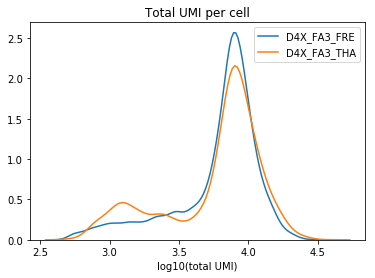

In [232]:
sns.distplot(combined['D4X_FA3_FRE'], hist=False, label='D4X_FA3_FRE')
sns.distplot(combined['D4X_FA3_THA'], hist=False, label='D4X_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

In [237]:
combined = {}
for sample in tqdm_notebook(sorted(data_dict)):
    sample_name = '_'.join(sample.split('_')[:3])
    if sample_name not in threshold_dict.keys():
        continue
    tmp = data_dict[sample].to_df()
    combined[sample_name] = tmp

In [238]:
fre_pred = clf.predict(scaler.fit_transform(combined['D4X_FA3_FRE']))
tha_pred = clf.predict(scaler.fit_transform(combined['D4X_FA3_THA']))

combined['D4X_FA3_FRE'][~fre_pred]
combined['D4X_FA3_THA'][~tha_pred]

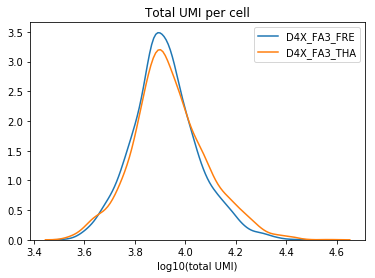

In [244]:
sns.distplot(np.log10(np.sum(combined['D4X_FA3_FRE'][~fre_pred],axis=1)+1), hist=False, label='D4X_FA3_FRE')
sns.distplot(np.log10(np.sum(combined['D4X_FA3_THA'][~tha_pred],axis=1)+1), hist=False, label='D4X_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

# bootstraps

load results from scripts

In [5]:
res = pd.read_csv("../results/threshold_ml.csv")
res_auc = res.filter(regex=(".*AUC.*"))
res_auc = pd.melt(res_auc, value_vars=res_auc.columns, value_name='AUC', var_name='dataset')
res_acc = res.filter(regex=(".*Accuracy.*"))
res_acc = pd.melt(res_acc, value_vars=res_acc.columns, value_name='accuracy', var_name='dataset')
res_f1 = res.filter(regex=(".*F1.*"))
res_f1 = pd.melt(res_f1, value_vars=res_f1.columns, value_name='F1', var_name='dataset')

In [6]:
ttest_ind(
    res_acc[res_acc['dataset'] == 'holdout_tha_Accuracy_freshonly']
    ['accuracy'], res_acc[res_acc['dataset'] ==
                          'holdout_tha_Accuracy_both']['accuracy'])

Ttest_indResult(statistic=6.36271267147901, pvalue=3.333969121773967e-10)

In [7]:
ttest_ind(
    res_f1[res_f1['dataset'] == 'holdout_tha_F1_freshonly']
    ['F1'], res_f1[res_f1['dataset'] ==
                          'holdout_tha_F1_both']['F1'])

Ttest_indResult(statistic=8.913784559435438, pvalue=3.2919183336603997e-18)

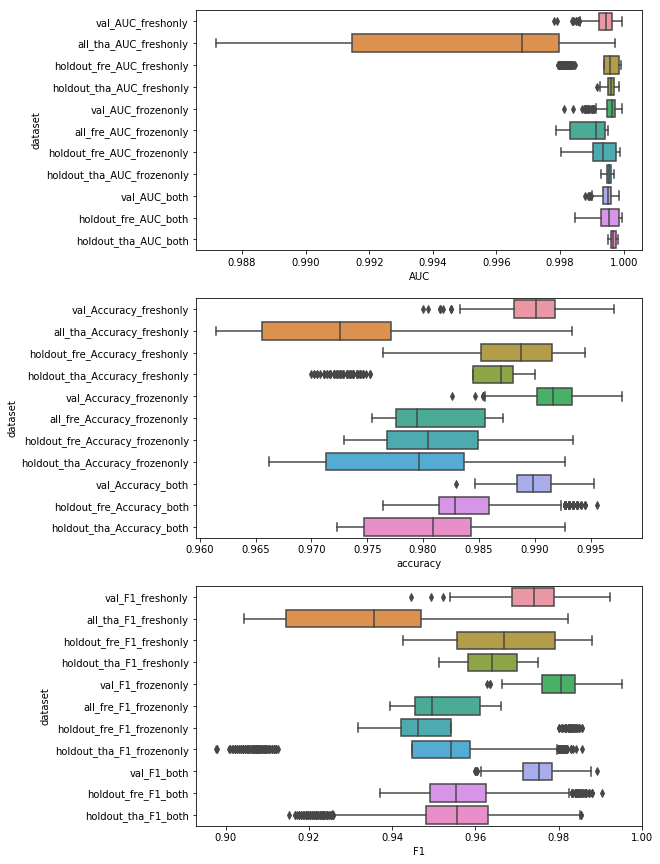

In [8]:
fig, ax = plt.subplots(3,1, figsize=(8,15), sharey=False)
sns.boxplot('AUC', 'dataset', data=res_auc, orient="h", ax=ax[0])
sns.boxplot('accuracy', 'dataset', data=res_acc, orient="h", ax=ax[1])
sns.boxplot('F1', 'dataset', data=res_f1, orient="h", ax=ax[2])

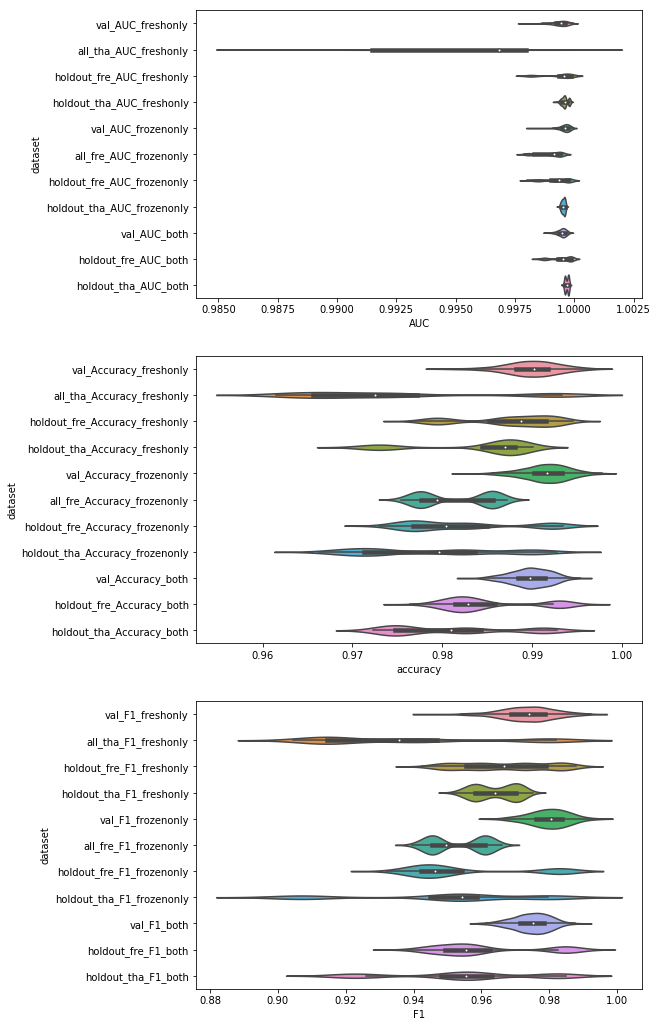

In [9]:
fig, ax = plt.subplots(3,1, figsize=(8,18), sharey=False)
sns.violinplot('AUC', 'dataset', data=res_auc, orient="h", ax=ax[0])
sns.violinplot('accuracy', 'dataset', data=res_acc, orient="h", ax=ax[1])
sns.violinplot('F1', 'dataset', data=res_f1, orient="h", ax=ax[2])

In [10]:
res.describe()

,val_AUC_freshonly,val_Accuracy_freshonly,val_F1_freshonly,all_tha_AUC_freshonly,all_tha_Accuracy_freshonly,all_tha_F1_freshonly,holdout_fre_AUC_freshonly,holdout_fre_Accuracy_freshonly,holdout_fre_F1_freshonly,holdout_tha_AUC_freshonly,...,holdout_tha_F1_frozenonly,val_AUC_both,val_Accuracy_both,val_F1_both,holdout_fre_AUC_both,holdout_fre_Accuracy_both,holdout_fre_F1_both,holdout_tha_AUC_both,holdout_tha_Accuracy_both,holdout_tha_F1_both
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,...,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,0.999381,0.989941,0.973496,0.994992,0.974727,0.937255,0.999308,0.987350,0.966793,0.999590,...,0.948451,0.999465,0.989789,0.974666,0.999448,0.984798,0.960307,0.999675,0.980863,0.954135
std,0.000332,0.003019,0.007859,0.003780,0.011013,0.026982,0.000673,0.005023,0.013000,0.000134,...,0.026469,0.000178,0.002179,0.005407,0.000450,0.005004,0.014961,0.000076,0.006846,0.021320
min,0.997820,0.979964,0.944444,0.987188,0.961466,0.904408,0.997938,0.976447,0.942512,0.999172,...,0.897740,0.998794,0.982928,0.959835,0.998474,0.976447,0.937031,0.999494,0.972280,0.915254
25%,0.999215,0.988189,0.968750,0.991457,0.965585,0.914535,0.999370,0.985202,0.955477,0.999497,...,0.944759,0.999358,0.988376,0.971316,0.999289,0.981408,0.949127,0.999605,0.974720,0.948148
50%,0.999439,0.990157,0.974093,0.996815,0.972557,0.935572,0.999562,0.988732,0.966744,0.999584,...,0.954242,0.999492,0.989812,0.975272,0.999529,0.982817,0.955449,0.999676,0.980933,0.955609
75%,0.999618,0.991803,0.978836,0.997975,0.977155,0.946958,0.999839,0.991587,0.978988,0.999686,...,0.958709,0.999591,0.991425,0.978404,0.999837,0.985915,0.962575,0.999742,0.984297,0.963033
max,0.999943,0.997082,0.992288,0.999723,0.993354,0.982120,0.999925,0.994514,0.987990,0.999854,...,0.985482,0.999838,0.995305,0.989163,0.999932,0.995611,0.990385,0.999820,0.992755,0.985445


# final demo

In [4]:
threshold_dict = {'D1X_FA2_FRE': 4000,
                 'D1X_FA2_THA': 3500,
                 'D1X_FA3_FRE': 6000,
                 'D1A_FA3_THA': 9000,
                 'D4X_FA2_FRE': 5000,
                 'D4X_FA2_THA': 4000,
                 'D4X_FA3_FRE': 4000,
                 'D4X_FA3_THA': 4000}

In [5]:
combined = {}
for sample in tqdm_notebook(sorted(data_dict)):
    sample_name = '_'.join(sample.split('_')[:3])
    tmp = data_dict[sample].to_df()
    if sample_name not in threshold_dict.keys():
        continue
    tmp['low_quality'] = tmp.apply(
        lambda row: True if np.sum(row) < threshold_dict[sample_name] else False,
        axis=1)
    tmp['sample'] = sample_name
    combined[sample_name] = tmp
combined_df = pd.concat(combined)
combined_df['sample'] = combined_df['sample'].str.replace('D1A','D1X')
combined_df = combined_df.reset_index(drop=True)

In [6]:
clf_dict = {}

In [23]:
for hold_out_sample in tqdm_notebook(['D1X_FA2']):
    combined_holdout_df = combined_df[combined_df['sample'].str.startswith(hold_out_sample)]
    combined_train_df = combined_df[~combined_df['sample'].str.startswith(hold_out_sample)]
    combined_train_fre_df = combined_train_df[combined_train_df['sample'].str.endswith('FRE')]
    combined_train_tha_df = combined_train_df[combined_train_df['sample'].str.endswith('THA')]
    combined_holdout_fre_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('FRE')]
    combined_holdout_tha_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('THA')]
    
    # both
    X = combined_train_df.drop(['low_quality', 'sample'], axis=1)
    y = combined_train_df['low_quality']

    X = StandardScaler().fit_transform(X)
    clf = LGBMClassifier(n_estimators=100, n_jobs=-1, objective='binary')
    clf.fit(X, y)
    clf_dict[hold_out_sample] = clf

In [7]:
for hold_out_sample in tqdm_notebook(['D1X_FA2', 'D1X_FA3', 'D4X_FA2', 'D4X_FA3']):
    combined_holdout_df = combined_df[combined_df['sample'].str.startswith(hold_out_sample)]
    combined_train_df = combined_df[~combined_df['sample'].str.startswith(hold_out_sample)]
    combined_train_fre_df = combined_train_df[combined_train_df['sample'].str.endswith('FRE')]
    combined_train_tha_df = combined_train_df[combined_train_df['sample'].str.endswith('THA')]
    combined_holdout_fre_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('FRE')]
    combined_holdout_tha_df = combined_holdout_df[combined_holdout_df['sample'].str.endswith('THA')]
    
    # both
    X = combined_train_df.drop(['low_quality', 'sample'], axis=1)
    y = combined_train_df['low_quality']

    X = StandardScaler().fit_transform(X)
    clf = LGBMClassifier(n_estimators=100, n_jobs=-1)
    clf.fit(X, y)
    clf_dict[hold_out_sample] = clf

In [24]:
pickle.dump(clf_dict, open("../models/clf_dict_both.pkl", "wb"))

In [56]:
combined = {}
for sample in tqdm_notebook(sorted(data_dict)):
    sample_name = '_'.join(sample.split('_')[:3])
    if sample_name not in threshold_dict.keys():
        continue
    tmp = data_dict[sample].to_df()
    combined[sample_name] = tmp

## D1_FA2

In [58]:
combined['D1X_FA2_FRE'].shape

(3987, 33538)

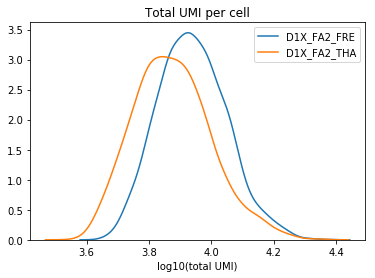

In [57]:
fre_pred = clf_dict['D1X_FA2'].predict(StandardScaler().fit_transform(combined['D1X_FA2_FRE']))
tha_pred = clf_dict['D1X_FA2'].predict(StandardScaler().fit_transform(combined['D1X_FA2_THA']))
sns.distplot(np.log10(np.sum(combined['D1X_FA2_FRE'][~fre_pred],axis=1)+1), hist=False, label='D1X_FA2_FRE')
sns.distplot(np.log10(np.sum(combined['D1X_FA2_THA'][~tha_pred],axis=1)+1), hist=False, label='D1X_FA2_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

In [60]:
print(f"FRE filtered {np.sum(fre_pred)}")
print(f"THA filtered {np.sum(tha_pred)}")

FRE filtered 700
THA filtered 1203


## D1_FA3

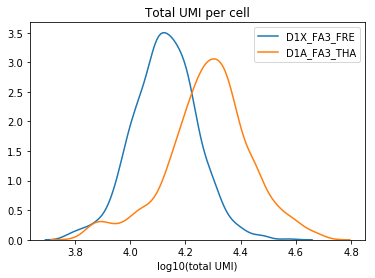

In [61]:
fre_pred = clf_dict['D1X_FA3'].predict(StandardScaler().fit_transform(combined['D1X_FA3_FRE']))
tha_pred = clf_dict['D1X_FA3'].predict(StandardScaler().fit_transform(combined['D1A_FA3_THA']))
sns.distplot(np.log10(np.sum(combined['D1X_FA3_FRE'][~fre_pred],axis=1)+1), hist=False, label='D1X_FA3_FRE')
sns.distplot(np.log10(np.sum(combined['D1A_FA3_THA'][~tha_pred],axis=1)+1), hist=False, label='D1A_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

In [62]:
print(f"FRE filtered {np.sum(fre_pred)}")
print(f"THA filtered {np.sum(tha_pred)}")

FRE filtered 632
THA filtered 1009


## D4_FA2

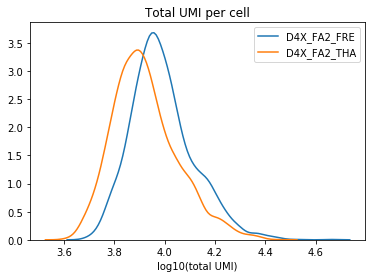

In [63]:
fre_pred = clf_dict['D4X_FA2'].predict(StandardScaler().fit_transform(combined['D4X_FA2_FRE']))
tha_pred = clf_dict['D4X_FA2'].predict(StandardScaler().fit_transform(combined['D4X_FA2_THA']))
sns.distplot(np.log10(np.sum(combined['D4X_FA2_FRE'][~fre_pred],axis=1)+1), hist=False, label='D4X_FA2_FRE')
sns.distplot(np.log10(np.sum(combined['D4X_FA2_THA'][~tha_pred],axis=1)+1), hist=False, label='D4X_FA2_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

In [64]:
print(f"FRE filtered {np.sum(fre_pred)}")
print(f"THA filtered {np.sum(tha_pred)}")

FRE filtered 697
THA filtered 975


## D4_FA3

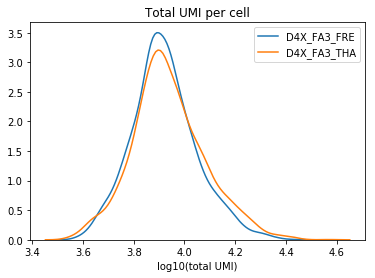

In [65]:
fre_pred = clf_dict['D4X_FA3'].predict(StandardScaler().fit_transform(combined['D4X_FA3_FRE']))
tha_pred = clf_dict['D4X_FA3'].predict(StandardScaler().fit_transform(combined['D4X_FA3_THA']))
sns.distplot(np.log10(np.sum(combined['D4X_FA3_FRE'][~fre_pred],axis=1)+1), hist=False, label='D4X_FA3_FRE')
sns.distplot(np.log10(np.sum(combined['D4X_FA3_THA'][~tha_pred],axis=1)+1), hist=False, label='D4X_FA3_THA')
plt.legend()
plt.title('Total UMI per cell')
plt.xlabel("log10(total UMI)")
plt.show()

In [66]:
print(f"FRE filtered {np.sum(fre_pred)}")
print(f"THA filtered {np.sum(tha_pred)}")

FRE filtered 762
THA filtered 1168


# SHAP

In [10]:
clf_dict = pickle.load(open("../models/clf_dict_both.pkl", "rb"))

In [12]:
combined = {}
for sample in tqdm_notebook(sorted(data_dict)):
    sample_name = '_'.join(sample.split('_')[:3])
    if sample_name not in threshold_dict.keys():
        continue
    tmp = data_dict[sample].to_df()
    combined[sample_name] = tmp

## D1 FA2

In [52]:
explainer = shap.TreeExplainer(clf_dict['D1X_FA2'])

shap_values = explainer.shap_values(StandardScaler().fit_transform(
    pd.concat([combined['D1X_FA2_FRE'], combined['D1X_FA2_THA']])))

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


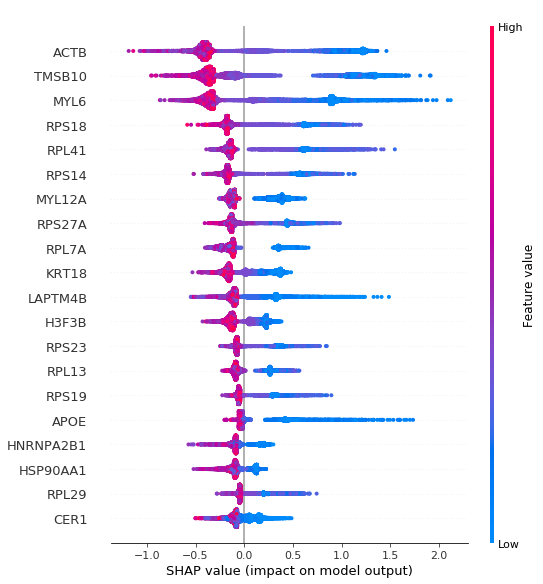

In [55]:
shap.summary_plot(
    shap_values[1],
    pd.DataFrame(StandardScaler().fit_transform(
        pd.concat([combined['D1X_FA2_FRE'], combined['D1X_FA2_THA']])),
                 columns=combined['D1X_FA2_FRE'].columns))

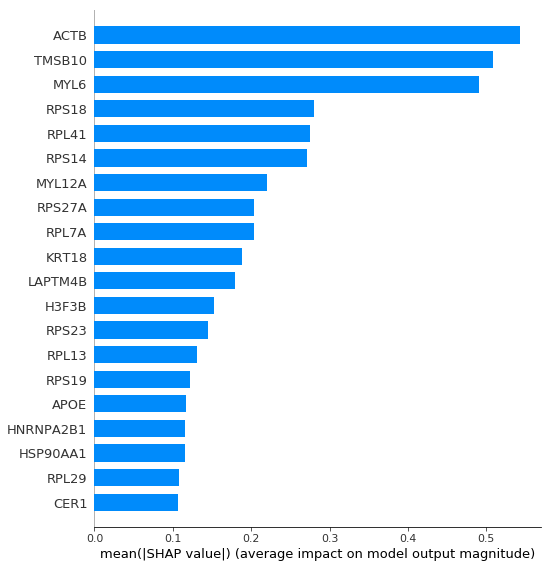

In [56]:
shap.summary_plot(
    shap_values[1],
    pd.DataFrame(StandardScaler().fit_transform(combined['D1X_FA2_FRE']),
                 columns=combined['D1X_FA2_FRE'].columns), plot_type='bar')

## D1 FA3

In [57]:
explainer = shap.TreeExplainer(clf_dict['D1X_FA3'])

shap_values = explainer.shap_values(StandardScaler().fit_transform(
    pd.concat([combined['D1X_FA3_FRE'], combined['D1A_FA3_THA']])))

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


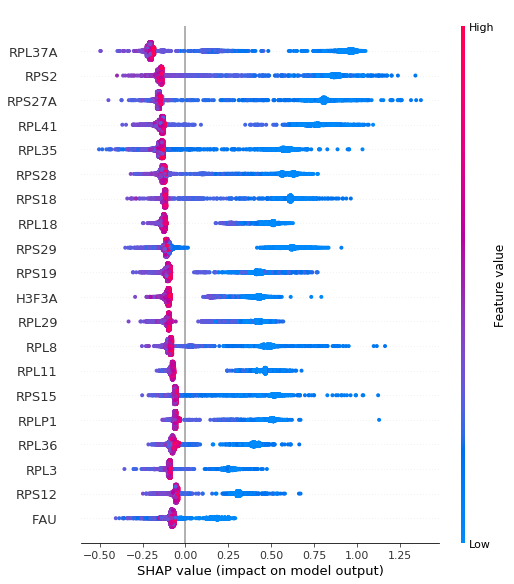

In [59]:
shap.summary_plot(
    shap_values[1],
    pd.DataFrame(StandardScaler().fit_transform(
        pd.concat([combined['D1X_FA3_FRE'], combined['D1A_FA3_THA']])),
                 columns=combined['D1X_FA3_FRE'].columns))

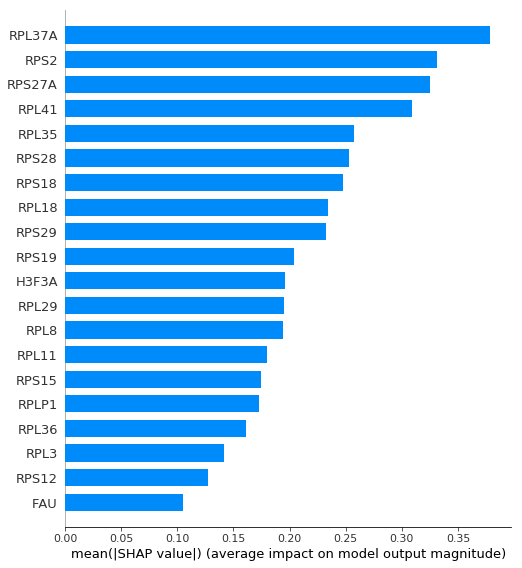

In [60]:
shap.summary_plot(shap_values[1],
                  pd.DataFrame(StandardScaler().fit_transform(
                      pd.concat(
                          [combined['D1X_FA3_FRE'], combined['D1A_FA3_THA']])),
                               columns=combined['D1X_FA3_FRE'].columns),
                  plot_type='bar')

## D4 FA2

In [62]:
explainer = shap.TreeExplainer(clf_dict['D4X_FA2'])

shap_values = explainer.shap_values(StandardScaler().fit_transform(
    pd.concat([combined['D4X_FA2_FRE'], combined['D4X_FA2_THA']])))

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


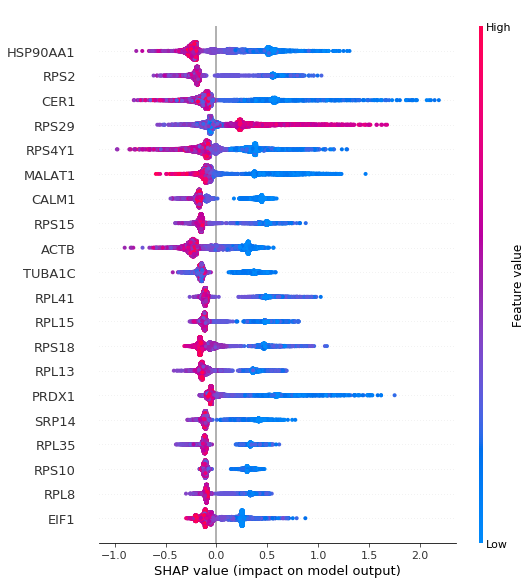

In [63]:
shap.summary_plot(
    shap_values[1],
    pd.DataFrame(StandardScaler().fit_transform(
        pd.concat([combined['D4X_FA2_FRE'], combined['D4X_FA2_THA']])),
                 columns=combined['D4X_FA2_FRE'].columns))

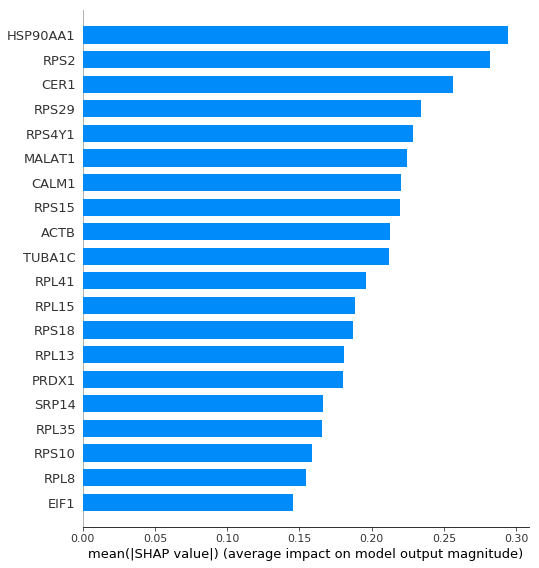

In [64]:
shap.summary_plot(shap_values[1],
                  pd.DataFrame(StandardScaler().fit_transform(
                      pd.concat(
                          [combined['D4X_FA2_FRE'], combined['D4X_FA2_THA']])),
                               columns=combined['D4X_FA2_FRE'].columns),
                  plot_type='bar')

## D4 FA3

In [65]:
explainer = shap.TreeExplainer(clf_dict['D4X_FA3'])

shap_values = explainer.shap_values(StandardScaler().fit_transform(
    pd.concat([combined['D4X_FA3_FRE'], combined['D4X_FA3_THA']])))

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/shap/explainers/tree.py:180: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


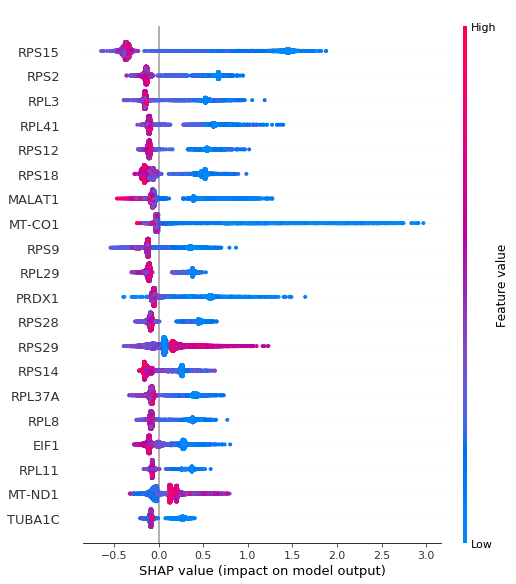

In [66]:
shap.summary_plot(
    shap_values[1],
    pd.DataFrame(StandardScaler().fit_transform(
        pd.concat([combined['D4X_FA3_FRE'], combined['D4X_FA3_THA']])),
                 columns=combined['D4X_FA3_FRE'].columns))

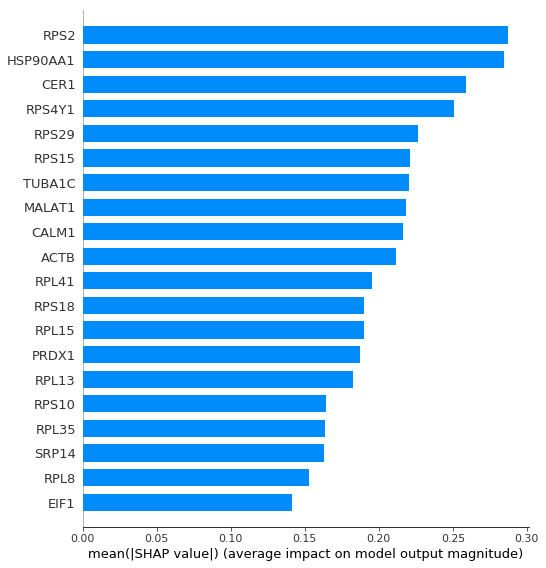

In [67]:
shap.summary_plot(
    shap_values_fre[1],
    pd.DataFrame(StandardScaler().fit_transform(
        pd.concat([combined['D4X_FA3_FRE'], combined['D4X_FA3_THA']])),
                 columns=combined['D4X_FA3_FRE'].columns), plot_type='bar')